# Using Scikit-learn's Random Forest Regressor

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_log_error, mean_squared_error, root_mean_squared_error
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("../data/processed/processed.csv")

In [7]:
data.head()

,Date,AQI,Year,Month,Day,temperature_2m_max,temperature_2m_min,precipitation_sum,weather_code,sunshine_duration,cloud_cover_mean,wind_speed_10m_mean,winddirection_10m_dominant
0,2018-01-01,75.0,2018,1,1,28.253,14.503,0.0,0.0,36062.707,0.000000,5.679092,270.61380
1,2018-01-02,76.0,2018,1,2,28.453,12.903,0.0,1.0,36040.188,7.166666,4.744073,278.32556
2,2018-01-03,79.0,2018,1,3,28.903,15.303,0.0,0.0,36101.605,0.083333,5.611268,285.88390
3,2018-01-04,84.0,2018,1,4,28.353,15.303,0.0,0.0,36083.652,1.541667,5.784296,326.56494
4,2018-01-05,97.0,2018,1,5,28.453,14.003,0.0,3.0,36066.500,46.125000,5.506170,287.77652


In [8]:
# Selecting Features for Training

features = ["Year", "Month", "temperature_2m_max", "temperature_2m_min",
            "precipitation_sum", "weather_code", "sunshine_duration", "cloud_cover_mean",
           "wind_speed_10m_mean", "winddirection_10m_dominant"]

X = data[features]
y = data["AQI"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print(f"Training data X Split Shape {X_train.shape}")
print(f"Training data Y Split Shape {y_train.shape}")

Training data X Split Shape (2045, 10)
Training data Y Split Shape (2045,)


In [11]:
# Initiating the model

model = RandomForestRegressor() # Using default n_estimators (100)

model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
# Checking how well model performed while learning

model.score(X_train, y_train)

0.9500539712107188

In [13]:
# Make predictions on the test set
predictions = model.predict(X_test)

In [15]:
# Evaluating performance

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmsle = root_mean_squared_log_error(y_test, predictions)

In [16]:
print("\n--- Model Evaluation ---")
print(f"R-squared (R²): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} AQI points")
print(f"Root Mean Squared Log Error (RMSLE): {rmsle:.2f}")
print("------------------------")


--- Model Evaluation ---
R-squared (R²): 0.65
Mean Absolute Error (MAE): 15.32 AQI points
Root Mean Squared Log Error (RMSLE): 0.20
------------------------


### Inference
A MAE of 16 points is not bad, but we can definitely try to find a better combination of max_depth and n_esimators using cross validations

In [20]:
# Let's save this model before proceeding further

import pickle
with open("../models/RFR-model.pkl", "wb") as f: 
    pickle.dump(model, f)

## Tuning Different Parameters to Find the best fit
We will use RandomSearchCV to check options to find the best model

In [41]:
%%time

rs_grid = {"n_estimators":np.arange(10,200,10),
        "max_depth":[None,10,20],
        "min_samples_split":np.arange(2,10,1),
        "min_samples_leaf":np.arange(1,10,1),
        "max_features":[0.5, 1.0, "sqrt"]}

# Setup instance of GridSearchCV to explore different parameters

rs_model = RandomizedSearchCV(estimator=RandomForestRegressor(),
                       n_jobs=-1,
                       param_distributions=rs_grid,
                       n_iter=100,
                       verbose=3,
                       cv=5,)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 4.41 s
Wall time: 40.9 s


,estimator,RandomForestRegressor()
,param_distributions,"{'max_depth': [None, 10, ...], 'max_features': [0.5, 1.0, ...], 'min_samples_leaf': array([1, 2, ..., 6, 7, 8, 9]), 'min_samples_split': array([2, 3, ..., 6, 7, 8, 9]), ...}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [42]:
rs_model.best_params_

{'n_estimators': np.int64(140),
 'min_samples_split': np.int64(3),
 'min_samples_leaf': np.int64(2),
 'max_features': 1.0,
 'max_depth': 20}

In [46]:
y_pred = rs_model.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("RMSLE:", root_mean_squared_log_error(y_test, y_pred))

R2: 0.6463790032329632
MAE: 15.453599184117223
MSE: 637.592125158149
RMSE: 25.25058662998048
RMSLE: 0.20309257520136528


## Inference
Hyperparameter tuning via RandomSearchCV did not improve performance significantly to the baseline RandomForest Model

## Finding the most important predictive features

In [47]:
best_model_feature_importances = model.feature_importances_
best_model_feature_importances

array([0.11933711, 0.0758137 , 0.15030303, 0.24186298, 0.11134311,
       0.01782406, 0.10453313, 0.04554196, 0.06175839, 0.07168253])

In [49]:
feature_importance_df = pd.DataFrame({"Feature_Names":features,
                                      "Feature_Importance":best_model_feature_importances}).sort_values(by="Feature_Importance",
                                                                                                        ascending=False)
feature_importance_df.head()

,Feature_Names,Feature_Importance
3,temperature_2m_min,0.241863
2,temperature_2m_max,0.150303
0,Year,0.119337
4,precipitation_sum,0.111343
6,sunshine_duration,0.104533


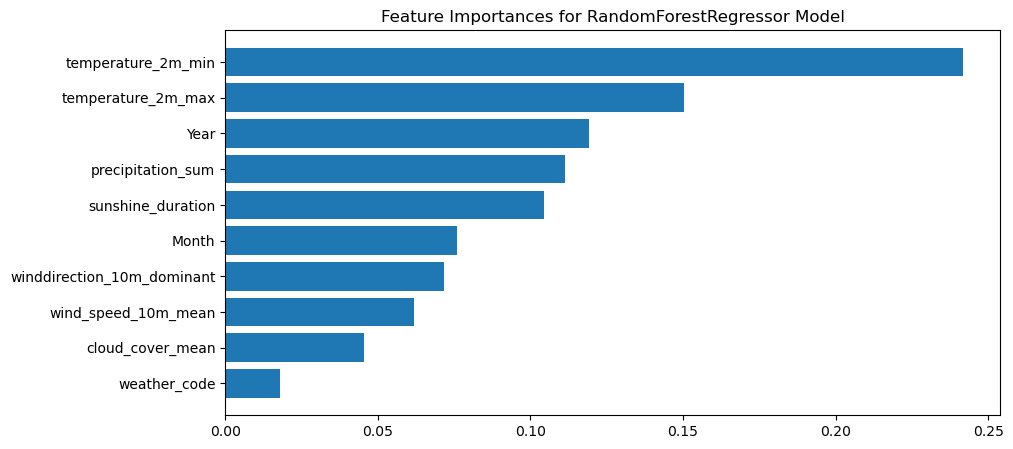

In [56]:
# Plot the features
plt.figure(figsize=(10,5))
plt.barh(y = feature_importance_df["Feature_Names"],
         width=feature_importance_df["Feature_Importance"])
plt.title("Feature Importances for RandomForestRegressor Model")
plt.gca().invert_yaxis();
plt.show()

## Inference
Looks like the top 5 features are Min/Max Temperature, Year, Precipitation sum and Sunshine duration